# Project Description
In this project I have some non linear data where there are two clusters/categories that I want to classify. I will do this by testing different classification algorithms (logistic regression, k nearest neighbors, desicion trees and random forests) and testing out which one gives the best results. I will go over the basics of what each algorithm does. We will analyze the score of each algorithm and see what it means or if its any good. 


In this project I will attempt to find the best performing machine learning classification algorithm to solve a problem. The problem in this project is we have some non linear data where we have two clusters or segments that are overlapping. We want to try and see which classification algorithm will best solve this issue. What I will do in this project is load my data in. Graph the data so we can see what it looks like and if it can give us insights onto how to solve the problem. I'll then use multiple classification algorithms to see which one performes best and gives the best accuracy. 

# Imports

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

# Loading Data

In [59]:
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')
X_test = pd.read_csv('./data/X_test.csv')
y_test = pd.read_csv('./data/y_test.csv')

In [60]:
X_train

,col1,col2
0,0.283087,-0.197163
1,0.986381,0.164478
2,-0.952769,0.303694
3,1.979364,0.297895
4,1.399762,-0.416619
...,...,...
599995,0.980339,0.197321
599996,0.570858,0.821049
599997,-0.518881,0.854846
599998,0.185451,-0.080095


# Graphing the Data
By graphing the data we can see what type of data were dealing with (linear/non linear). This is helpful to see what approach we can take or what it is the problem were solving. For example from graphing the data we can see that this is non linear data. We can also see that there are two clusters/groups that we can probably draw some boundary to seperate and classify. This of course is our task which is to see which classification algorithm can best 

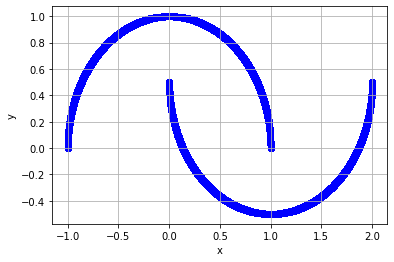

In [61]:
%matplotlib inline 
plt.scatter(X_train['col1'], X_train['col2'], color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show();

In [62]:
y_train = y_train['outputs'].to_numpy() # reformat data to numpy array so we can use it more easily

# Using Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression # import model

In [64]:
logistic_regression = LogisticRegression() # create the model 

In [65]:
logistic_regression = logistic_regression.fit(X_train, y_train) # train model on the training data

In [66]:
logistic_regression.score(X_test, y_test) # get test accuracy

0.894175

In [67]:
logistic_regression.score(X_train, y_train) # get train accuracy

0.8937433333333333

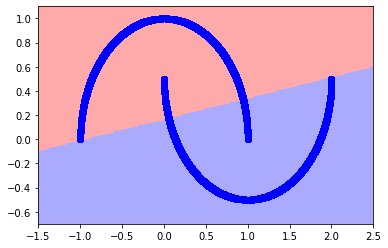

In [68]:
graph_boundary(logistic_regression)

# Using KNN
- This is used for classification
- There's no training but the complexity for predicting
- When we want to classify something we find its k(an odd number) nearest neighbors. We do this by measuring some distance between other data and the data we want to classify. A common distance is the Euclidean distance where d=sqrt((x-a)^2+(y-b)^2). We pick the nearest neighbors that have the closest smallest distance. From that we see which class is there more of and that's how we predict.
- Best for labeled data


In [69]:
from sklearn.neighbors import KNeighborsClassifier # import model

In [70]:
neighboors = KNeighborsClassifier(n_neighbors=7) # create model with 7 neighbors to define

In [71]:
neighboors = neighboors.fit(X_train, y_train) # train the model

In [72]:
neighboors.score(X_test, y_test) # get test accuracy

1.0

In [73]:
neighboors.fit(X_train, y_train).score(X_train, y_train) # get training accuracy

1.0

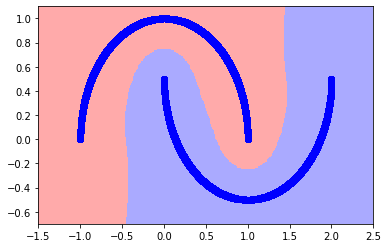

In [74]:
graph_boundary(neighboors)

# Using Descion Trees
- For classification
- We train the model by getting some data and splitting it into binary categories and we stop until we can't split them anymore. Prediction is O(1)
- There can be lots of parameters
- When we want to predict we just put our new data through our tree and classify something

In [75]:
from sklearn import tree # import model

In [76]:
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)

In [77]:
tree_clf.predict(X_test)

array([0, 0, 0, ..., 0, 1, 1])

In [78]:
tree_clf.score(X_train, y_train)

1.0

In [79]:
tree_clf.score(X_test, y_test)

0.99996

[Text(167.40000000000003, 199.32, 'X[1] <= 0.5\ngini = 0.5\nsamples = 600000\nvalue = [299941, 300059]'),
 Text(66.96000000000001, 163.07999999999998, 'X[0] <= -0.433\ngini = 0.375\nsamples = 400072\nvalue = [100016, 300056]'),
 Text(33.480000000000004, 126.83999999999999, 'gini = 0.0\nsamples = 49944\nvalue = [49944, 0]'),
 Text(100.44000000000001, 126.83999999999999, 'X[1] <= 0.0\ngini = 0.245\nsamples = 350128\nvalue = [50072, 300056]'),
 Text(66.96000000000001, 90.6, 'gini = 0.0\nsamples = 200010\nvalue = [0, 200010]'),
 Text(133.92000000000002, 90.6, 'X[0] <= 0.5\ngini = 0.445\nsamples = 150118\nvalue = [50072, 100046]'),
 Text(100.44000000000001, 54.359999999999985, 'gini = 0.0\nsamples = 50090\nvalue = [0, 50090]'),
 Text(167.40000000000003, 54.359999999999985, 'X[0] <= 1.433\ngini = 0.5\nsamples = 100028\nvalue = [50072, 49956]'),
 Text(133.92000000000002, 18.119999999999976, 'gini = 0.0\nsamples = 50072\nvalue = [50072, 0]'),
 Text(200.88000000000002, 18.119999999999976, 'gini

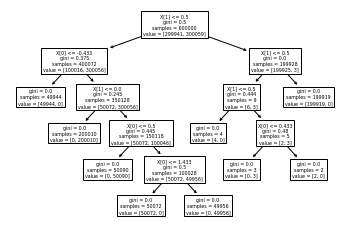

In [80]:
tree.plot_tree(tree_clf)

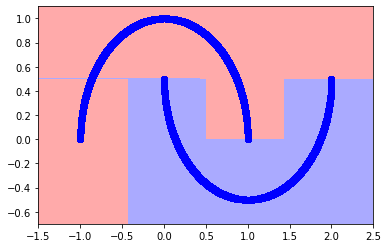

In [81]:
graph_boundary(tree_clf)

# Using Random Forests

In [82]:
def graph_boundary(model):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading="auto")
    plt.scatter(X_train['col1'], X_train['col2'], color='b')
    plt.xlim([-1.5, 2.5])
    plt.ylim([-.7, 1.1])
    plt.show()